<a href="https://colab.research.google.com/github/ssegovba/identifying-deforestation/blob/main/notebooks/may10_cv_final_project_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained models

This notebook outlines the data processing and model building and fitting from pre-trained models for our satellite images



## Data Pre-processing

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image

from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# data_path = "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/"
# train_path = "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/train-jpg/"
# test_path = "/content/drive/Shareddrives/computer-vision-project/Data/Unzipped/planet/planet/test-jpg"

data_path = "/content/drive/Shareddrives/computer-vision-project/Data/"
train_path = "/content/drive/Shareddrives/computer-vision-project/Data/train-jpg/"

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import os

In [ ]:
# Load the CSV file with the metadata
labels_df = pd.read_csv(data_path + 'train_classes.csv')

# Add extension so image names match file names
labels_df['image_name'] = labels_df['image_name'].apply(lambda x: x + '.jpg')

# Convert the space-separated tags into a list of tags
labels_df['tags'] = labels_df['tags'].apply(lambda x: x.split())

In [ ]:
unique_tags = labels_df['tags'].explode().unique()

for tag in unique_tags:
    print(tag)

haze
primary
agriculture
clear
water
habitation
road
cultivation
slash_burn
cloudy
partly_cloudy
conventional_mine
bare_ground
artisinal_mine
blooming
selective_logging
blow_down


In [ ]:
natural_deforestation = ['bare_ground', 'blow_down']

In [ ]:
forest = ['primary', 'blooming']

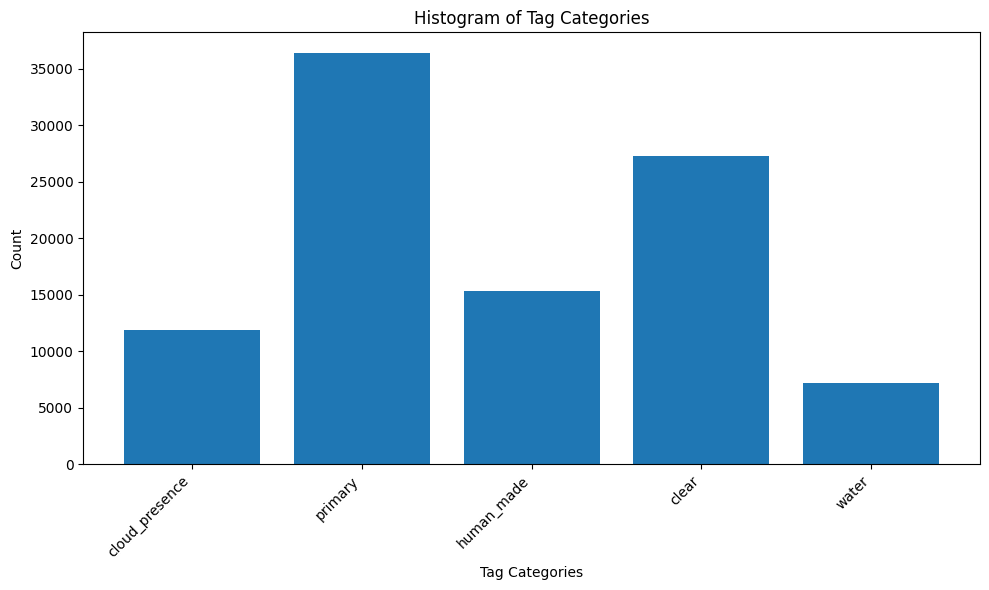

In [ ]:
# group all man-made tags into a "human" category to reduce the number of classes
human_tags = ['agriculture', 'road', 'habitation', 'cultivation', 'slash_burn', 'selective_logging', 'conventional_mine', 'artisinal_mine']

def categorize_tags_man_made(tags):
    if any(tag in human_tags for tag in tags):
        return ['human_made'] + [tag for tag in tags if tag not in human_tags]
    else:
        return tags

labels_df['tag_category'] = labels_df['tags'].apply(categorize_tags_man_made)
labels_df["image_name"] = train_path + labels_df["image_name"]

# what if we group cloudy images and filter dataframe to exclude the less frequently occurring classes?
cloudy_tags = ["cloudy", "partly_cloudy", "haze"]

def categorize_tags_cloudy(tags):
    if any(tag in cloudy_tags for tag in tags):
        return ['cloud_presence'] + [tag for tag in tags if tag not in cloudy_tags]
    else:
        return tags

labels_df['tag_category'] = labels_df['tag_category'].apply(categorize_tags_cloudy)

to_remove = ["bare_ground", "blooming", "blow_down"]

def remove_rows(tags):
    return any(tag in to_remove for tag in tags)

labels_df_fltr = labels_df[~labels_df['tag_category'].apply(remove_rows)]
labels_df_fltr.shape

tag_categories_flat = [tag for tags in labels_df_fltr['tag_category'] for tag in tags]

tag_category_counts = Counter(tag_categories_flat)

plt.figure(figsize=(10, 6))
plt.bar(tag_category_counts.keys(), tag_category_counts.values())
plt.xlabel('Tag Categories')
plt.ylabel('Count')
plt.title('Histogram of Tag Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
labels_df_fltr['tag_category'].value_counts()

tag_category
[clear, primary]                                13636
[human_made, clear, primary]                     8099
[cloud_presence, primary]                        5101
[human_made, clear, primary, water]              3112
[cloud_presence, human_made, primary]            2779
[cloud_presence]                                 2090
[clear, primary, water]                          1850
[cloud_presence, human_made, primary, water]      922
[cloud_presence, primary, water]                  909
[clear, water]                                    261
[human_made, clear]                               259
[human_made, clear, water]                         78
[cloud_presence, human_made]                       45
[cloud_presence, water]                            29
[cloud_presence, human_made, water]                24
[water]                                             1
Name: count, dtype: int64

In [ ]:
# # group all man-made tags into a "human" category to reduce the number of classes
# human_tags = ['agriculture', 'road', 'habitation', 'cultivation', 'slash_burn', 'selective_logging', 'conventional_mine', 'artisinal_mine']

# def categorize_tags_human(tags):
#     if any(tag in human_tags for tag in tags):
#         return ['human_made'] + [tag for tag in tags if tag not in human_tags]
#     else:
#         return tags

# labels_df['tag_category'] = labels_df['tags'].apply(categorize_tags_human)

In [ ]:
# labels_df["image_name"] = train_path + labels_df["image_name"]
# labels_df

,image_name,tags,tag_category
0,/content/drive/Shareddrives/computer-vision-pr...,"[haze, primary]","[haze, primary]"
1,/content/drive/Shareddrives/computer-vision-pr...,"[agriculture, clear, primary, water]","[human_made, clear, primary, water]"
2,/content/drive/Shareddrives/computer-vision-pr...,"[clear, primary]","[clear, primary]"
3,/content/drive/Shareddrives/computer-vision-pr...,"[clear, primary]","[clear, primary]"
4,/content/drive/Shareddrives/computer-vision-pr...,"[agriculture, clear, habitation, primary, road]","[human_made, clear, primary]"
...,...,...,...
40474,/content/drive/Shareddrives/computer-vision-pr...,"[clear, primary]","[clear, primary]"
40475,/content/drive/Shareddrives/computer-vision-pr...,[cloudy],[cloudy]
40476,/content/drive/Shareddrives/computer-vision-pr...,"[agriculture, clear, primary]","[human_made, clear, primary]"
40477,/content/drive/Shareddrives/computer-vision-pr...,"[agriculture, clear, primary, road]","[human_made, clear, primary]"


In [ ]:
# labels_df["image_name"][0]

'/content/drive/Shareddrives/computer-vision-project/Data/train-jpg/train_0.jpg'

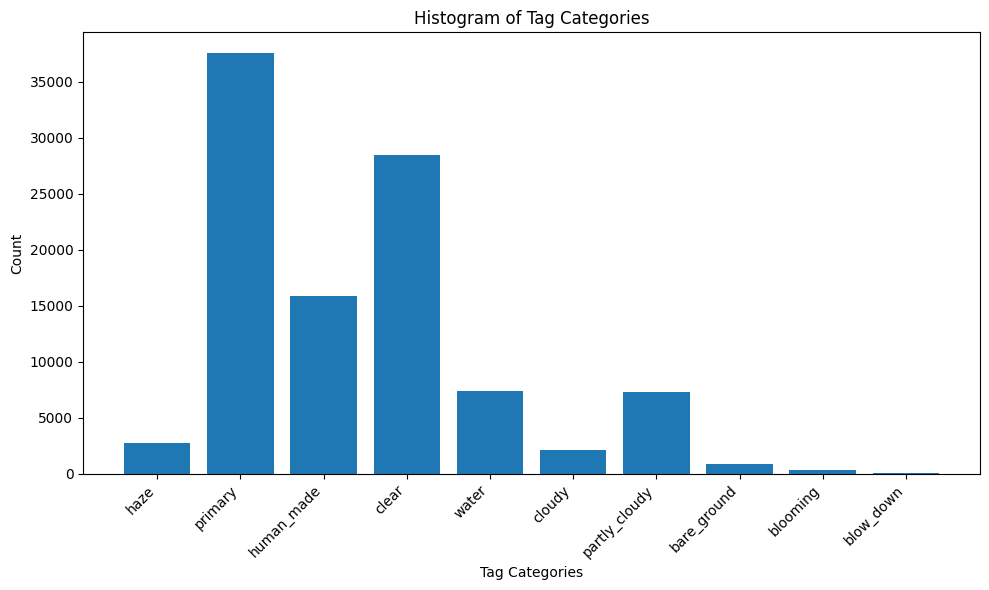

In [ ]:
# import matplotlib.pyplot as plt
# from collections import Counter

# tag_categories_flat = [tag for tags in labels_df['tag_category'] for tag in tags]

# tag_category_counts = Counter(tag_categories_flat)

# plt.figure(figsize=(10, 6))
# plt.bar(tag_category_counts.keys(), tag_category_counts.values())
# plt.xlabel('Tag Categories')
# plt.ylabel('Count')
# plt.title('Histogram of Tag Categories')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.tight_layout()
# plt.show()

In [ ]:
# # what if we group cloudy images and filter dataframe to exclude the less frequently occuring classes?
# cloudy_tags = ["cloudy", "partly_cloudy", "haze"]

# def categorize_tags_cloudy(tags):
#     if any(tag in cloudy_tags for tag in tags):
#         return ['cloud_presence'] + [tag for tag in tags if tag not in cloudy_tags]
#     else:
#         return tags

# labels_df['tag_category'] = labels_df['tags'].apply(categorize_tags_cloudy)

# to_remove = ["bare_ground", "blooming", "blow_down"]

# def remove_rows(tags):
#     return any(tag in to_remove for tag in tags)

# labels_df_fltr = labels_df[~labels_df['tag_category'].apply(remove_rows)]
# labels_df_fltr.shape

(39195, 3)

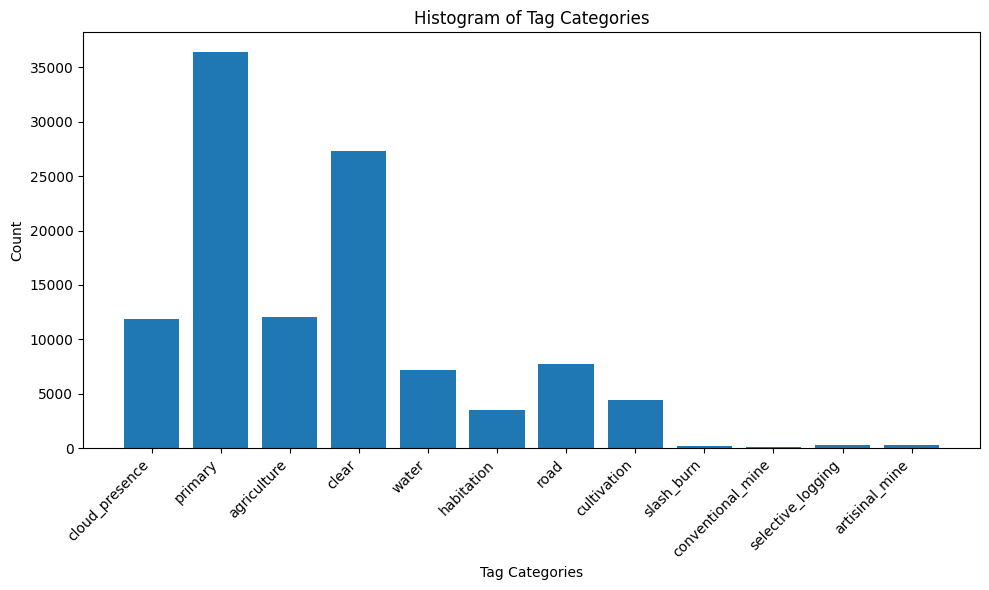

In [ ]:
# tag_categories_flat = [tag for tags in labels_df_fltr['tag_category'] for tag in tags]

# tag_category_counts = Counter(tag_categories_flat)

# plt.figure(figsize=(10, 6))
# plt.bar(tag_category_counts.keys(), tag_category_counts.values())
# plt.xlabel('Tag Categories')
# plt.ylabel('Count')
# plt.title('Histogram of Tag Categories')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.tight_layout()
# plt.show()

In [ ]:
# labels_df_fltr['tag_category'].value_counts()

tag_category
[clear, primary]                       13636
[human_made, clear, primary]            8099
[human_made, clear, primary, water]     3112
[clear, primary, water]                 1850
[clear, water]                           261
[human_made, clear]                      259
[human_made, clear, water]                78
[water]                                    1
Name: count, dtype: int64

### Sample data to see if models run faster

In [ ]:
sampled_df = labels_df_fltr.sample(n=15000, random_state=42)
sampled_df.reset_index(drop=True, inplace=True)

In [ ]:
sampled_df.shape

(15000, 3)

In [ ]:
# create validataion set
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(sampled_df, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10)

In [ ]:
image_height = 128
image_width = 128
batch_size = 64

filtered_train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_name',
    y_col='tag_category',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_name',
    y_col='tag_category',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8448 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3552 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


Found 2095 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 905 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


# Building the Pre-trained models

In [ ]:
from keras.applications import VGG16, ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard

In [ ]:
# set number of classes/labels
num_classes = len(set(tag_categories_flat))
num_classes

5

In [ ]:
from keras import backend as K

# from ChatGPT - custom F1 function to be used in metrics when compiling the model

def f1_score(y_true, y_pred):
    # Convert predictions to binary values
    y_pred = K.round(y_pred)

    # Calculate true positives, false positives, and false negatives
    TP = K.sum(K.round(y_true * y_pred), axis=0)
    FP = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    FN = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)

    # Calculate precision and recall
    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())

    # Calculate F1-score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Average F1-score across all classes
    f1 = K.mean(f1)

    return f1

## ResNet

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in resnet_model.layers[:-2]:
    layer.trainable = False

In [ ]:
# add a custom layer on top
x = GlobalAveragePooling2D()(resnet_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

In [ ]:
model_resnet = Model(inputs=resnet_model.input, outputs=predictions)

In [ ]:
model_resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
model_resnet.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', f1_score])

In [ ]:
# add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9  # reduce learning rate by 10% every 10 epochs
    return lr
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

model_resnet.fit(filtered_train_generator,
                 epochs=3,
                 steps_per_epoch=100,
                 validation_data=val_generator,
                 validation_steps=30,
                 callbacks=[early_stopping, lr_scheduler_callback, tensorboard_callback])

Epoch 1/3
100/100 [==============================] - 79s 749ms/step - loss: 0.5206 - accuracy: 0.0000e+00 - f1_score: 0.3623 - val_loss: 0.5162 - val_accuracy: 0.0000e+00 - val_f1_score: 0.3706 - lr: 0.0010
Epoch 2/3
100/100 [==============================] - 72s 724ms/step - loss: 0.5162 - accuracy: 0.0000e+00 - f1_score: 0.3678 - val_loss: 0.5145 - val_accuracy: 0.0000e+00 - val_f1_score: 0.3638 - lr: 0.0010
Epoch 3/3
100/100 [==============================] - 69s 693ms/step - loss: 0.5168 - accuracy: 0.0000e+00 - f1_score: 0.3787 - val_loss: 0.5092 - val_accuracy: 0.0000e+00 - val_f1_score: 0.3950 - lr: 0.0010


## VGG

In [ ]:
# load the VGG model without the top layers (include_top=False)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

In [ ]:
for layer in vgg_model.layers[:-2]: # unfreeze the last to layers to allow fine-tuning
    layer.trainable = False

# add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9  # reduce learning rate by 10% every 10 epochs
    return lr
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

x = Flatten()(vgg_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

model_vgg = Model(inputs=vgg_model.input, outputs=predictions)

In [ ]:
model_vgg.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', f1_score])
model_vgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
vgg_history = model_vgg.fit(filtered_train_generator,
                            epochs=3,
                            steps_per_epoch=100,
                            validation_data=val_generator,
                            validation_steps=30,
                            callbacks=[early_stopping, lr_scheduler_callback, tensorboard_callback])

Epoch 1/3
100/100 [==============================] - 1641s 16s/step - loss: 0.3657 - accuracy: 0.1123 - f1_score: 0.6961 - val_loss: 0.2640 - val_accuracy: 0.1281 - val_f1_score: 0.8000 - lr: 0.0010
Epoch 2/3
100/100 [==============================] - 341s 3s/step - loss: 0.2776 - accuracy: 0.1470 - f1_score: 0.7900 - val_loss: 0.2606 - val_accuracy: 0.1036 - val_f1_score: 0.8119 - lr: 0.0010
Epoch 3/3
100/100 [==============================] - 135s 1s/step - loss: 0.2686 - accuracy: 0.1405 - f1_score: 0.7985 - val_loss: 0.2698 - val_accuracy: 0.0812 - val_f1_score: 0.7996 - lr: 0.0010


In [ ]:
vgg_history = model_vgg.fit(filtered_train_generator,
                            epochs=10,
                            steps_per_epoch=100,
                            validation_data=val_generator,
                            validation_steps=30,
                            callbacks=[early_stopping, lr_scheduler_callback, tensorboard_callback])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.0537 

KeyboardInterrupt: 

## EfficientNet

Should be faster (?)